In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

La arquitectura mTAN es un modelo basado en transformers diseñado específicamente para manejar series temporales irregulares (con observaciones en momentos no uniformes). 

## Time Positional Encoding

- Toma timestamps reales como entrada
- Aplica una transformación lineal aprendible
- Aplica una función coseno para capturar patrones periódicos

Salida: Vector de dimensión d_model que representa el tiempo

Interpretación: Esta codificación permite al modelo entender la distancia temporal real entre las observaciones

In [2]:
# 1. TIME-ABSOLUTE POSITIONAL ENCODING
class TimeAbsolutePositionalEncoding(nn.Module):
    """
    Codificación posicional que incorpora información temporal absoluta.
    A diferencia de los transformers estándar, aquí usamos los timestamps reales.
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.d_model = d_model
        
        # Parámetros aprendibles para la codificación temporal
        self.w = nn.Parameter(torch.randn(1, d_model))
        self.b = nn.Parameter(torch.randn(1, d_model))
        
    def forward(self, timestamps):
        """
        Args:
            timestamps: (batch_size, seq_len) - timestamps reales
        Returns:
            (batch_size, seq_len, d_model) - codificación temporal
        """
        # Expandir timestamps para cada dimensión del embedding
        # timestamps: (B, L) -> (B, L, 1)
        timestamps = timestamps.unsqueeze(-1)
        
        # Aplicar transformación lineal aprendible
        # (B, L, 1) * (1, d_model) = (B, L, d_model)
        time_encoding = timestamps * self.w + self.b
        
        # Aplicar función periódica (coseno) para capturar patrones cíclicos
        time_encoding = torch.cos(time_encoding)
        
        return time_encoding

## MultiTime Attention

Mecanismo de atención que considera tanto el valor de la observación como el tiempo

Componentes clave:

- Codificación temporal separada para queries y keys
- Combinación de embeddings de contenido + embeddings temporales
- Atención multi-cabeza estándar sobre la representación combinada

Query + Time_Query_Encoding → Q

Key + Time_Key_Encoding → K

Value → V

Interpretación: Este mecanismo de atención permite que el modelo atienda a observaciones relevantes considerando cuándo ocurrieron, no solo qué valores tienen.

In [3]:
# 2. MULTI-TIME ATTENTION MECHANISM
class MultiTimeAttention(nn.Module):
    """
    Mecanismo de atención que incorpora información temporal en el cálculo.
    La clave es que la atención depende tanto del contenido como del tiempo.
    """
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Proyecciones lineales para Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Proyección de salida
        self.W_o = nn.Linear(d_model, d_model)
        
        # Codificación temporal para las queries y keys
        self.time_query = TimeAbsolutePositionalEncoding(d_model)
        self.time_key = TimeAbsolutePositionalEncoding(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, query_times, key_times, mask=None):
        """
        Args:
            query: (batch_size, query_len, d_model)
            key: (batch_size, key_len, d_model)
            value: (batch_size, key_len, d_model)
            query_times: (batch_size, query_len) - timestamps de las queries
            key_times: (batch_size, key_len) - timestamps de las keys
            mask: (batch_size, query_len, key_len) - máscara de atención
        """
        batch_size = query.size(0)
        
        # 1. Obtener codificaciones temporales
        time_query_encoding = self.time_query(query_times)  # (B, query_len, d_model)
        time_key_encoding = self.time_key(key_times)        # (B, key_len, d_model)
        
        # 2. Combinar información de contenido con información temporal
        query_with_time = query + time_query_encoding
        key_with_time = key + time_key_encoding
        
        # 3. Proyecciones lineales
        Q = self.W_q(query_with_time)  # (B, query_len, d_model)
        K = self.W_k(key_with_time)    # (B, key_len, d_model)
        V = self.W_v(value)            # (B, key_len, d_model)
        
        # 4. Dividir en múltiples cabezas
        # (B, L, d_model) -> (B, L, n_heads, d_k) -> (B, n_heads, L, d_k)
        Q = Q.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        # 5. Calcular scores de atención
        # (B, n_heads, query_len, d_k) x (B, n_heads, d_k, key_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 6. Aplicar máscara si existe (para ignorar valores faltantes)
        if mask is not None:
            # mask: (B, query_len, key_len) -> (B, 1, query_len, key_len)
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # 7. Aplicar softmax y dropout
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # 8. Aplicar atención a los valores
        # (B, n_heads, query_len, key_len) x (B, n_heads, key_len, d_k)
        context = torch.matmul(attention_weights, V)
        
        # 9. Concatenar cabezas
        # (B, n_heads, query_len, d_k) -> (B, query_len, n_heads, d_k)
        context = context.transpose(1, 2).contiguous()
        # (B, query_len, n_heads, d_k) -> (B, query_len, d_model)
        context = context.view(batch_size, -1, self.d_model)
        
        # 10. Proyección final
        output = self.W_o(context)
        
        return output, attention_weights


## FeedForward

Añade capacidad de procesamiento no lineal después de la atención.

In [4]:
# 3. FEED-FORWARD NETWORK
class FeedForward(nn.Module):
    """
    Red feed-forward de dos capas con activación ReLU.
    Estándar en arquitecturas transformer.
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # (B, L, d_model) -> (B, L, d_ff) -> (B, L, d_model)
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

## mTAN Encoder Layer

Combina atención y feed-forward.

In [5]:
# 4. ENCODER LAYER
class mTANEncoderLayer(nn.Module):
    """
    Una capa del encoder mTAN.
    Combina Multi-Time Attention + Feed-Forward con conexiones residuales.
    """
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        
        self.multi_time_attention = MultiTimeAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, timestamps, mask=None):
        """
        Args:
            x: (batch_size, seq_len, d_model) - entrada
            timestamps: (batch_size, seq_len) - timestamps
            mask: (batch_size, seq_len, seq_len) - máscara de atención
        """
        # 1. Multi-Time Attention con conexión residual
        attn_output, attn_weights = self.multi_time_attention(
            query=x, key=x, value=x,
            query_times=timestamps,
            key_times=timestamps,
            mask=mask
        )
        x = self.norm1(x + self.dropout(attn_output))
        
        # 2. Feed-Forward con conexión residual
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x, attn_weights

In [6]:
# 5. COMPLETE mTAN ENCODER
class mTANEncoder(nn.Module):
    """
    Encoder completo mTAN con múltiples capas.
    """
    def __init__(self, input_dim, d_model, n_heads, n_layers, d_ff, dropout=0.1):
        super().__init__()
        
        # Proyección de entrada
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Stack de capas encoder
        self.layers = nn.ModuleList([
            mTANEncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, timestamps, mask=None):
        """
        Args:
            x: (batch_size, seq_len, input_dim) - valores observados
            timestamps: (batch_size, seq_len) - timestamps
            mask: (batch_size, seq_len, seq_len) - máscara de atención
        """
        # Proyectar entrada al espacio del modelo
        x = self.input_projection(x)
        x = self.dropout(x)
        
        # Pasar por todas las capas
        attention_weights = []
        for layer in self.layers:
            x, attn_w = layer(x, timestamps, mask)
            attention_weights.append(attn_w)
        
        return x, attention_weights

## Classification

In [7]:
# 6. COMPLETE mTAN MODEL (for Classification/Regression)
class mTAN(nn.Module):
    """
    Modelo mTAN completo para tareas de clasificación o regresión
    con series temporales irregulares.
    """
    def __init__(self, input_dim, d_model, n_heads, n_layers, d_ff, 
                 output_dim, task='classification', dropout=0.1):
        super().__init__()
        
        self.task = task
        
        # Encoder mTAN
        self.encoder = mTANEncoder(
            input_dim=input_dim,
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            d_ff=d_ff,
            dropout=dropout
        )
        
        # Capa de agregación temporal (pooling)
        self.aggregation = 'mean'  # Puede ser 'mean', 'max', o 'last'
        
        # Cabeza de clasificación/regresión
        self.output_layer = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_dim)
        )
        
    def forward(self, x, timestamps, mask=None):
        """
        Args:
            x: (batch_size, seq_len, input_dim) - valores observados
            timestamps: (batch_size, seq_len) - timestamps
            mask: (batch_size, seq_len) - máscara de valores válidos (1=válido, 0=faltante)
        """
        # 1. Codificar secuencia
        batch_size, seq_len, _ = x.shape
        
        # Crear máscara de atención si se proporciona máscara de valores
        if mask is not None:
            # (B, L) -> (B, L, L) para atención
            attn_mask = mask.unsqueeze(1) * mask.unsqueeze(2)
        else:
            attn_mask = None
        
        # 2. Pasar por el encoder
        encoded, attention_weights = self.encoder(x, timestamps, attn_mask)
        # encoded: (B, L, d_model)
        
        # 3. Agregación temporal
        if self.aggregation == 'mean':
            if mask is not None:
                # Promedio solo sobre valores válidos
                mask_expanded = mask.unsqueeze(-1)  # (B, L, 1)
                aggregated = (encoded * mask_expanded).sum(dim=1) / mask_expanded.sum(dim=1)
            else:
                aggregated = encoded.mean(dim=1)
        elif self.aggregation == 'max':
            aggregated = encoded.max(dim=1)[0]
        elif self.aggregation == 'last':
            aggregated = encoded[:, -1, :]
        
        # aggregated: (B, d_model)
        
        # 4. Capa de salida
        output = self.output_layer(aggregated)
        
        if self.task == 'classification':
            output = F.log_softmax(output, dim=-1)
        
        return output, attention_weights

## Interpolación

Interpolar valores en timestamps arbitrarios usando Cross-attention

In [8]:
# 7. mTAN FOR INTERPOLATION
class mTANInterpolation(nn.Module):
    """
    Variante de mTAN para interpolación de series temporales.
    Predice valores en timestamps arbitrarios.
    """
    def __init__(self, input_dim, d_model, n_heads, n_layers, d_ff, dropout=0.1):
        super().__init__()
        
        self.encoder = mTANEncoder(
            input_dim=input_dim,
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            d_ff=d_ff,
            dropout=dropout
        )
        
        # Decoder para interpolación
        self.decoder_attention = MultiTimeAttention(d_model, n_heads, dropout)
        self.decoder_ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Proyección a valores originales
        self.output_projection = nn.Linear(d_model, input_dim)
        
    def forward(self, x, timestamps, query_timestamps, mask=None):
        """
        Args:
            x: (batch_size, seq_len, input_dim) - valores observados
            timestamps: (batch_size, seq_len) - timestamps observados
            query_timestamps: (batch_size, query_len) - timestamps donde interpolar
            mask: (batch_size, seq_len) - máscara de valores válidos
        """
        # 1. Codificar observaciones
        if mask is not None:
            attn_mask = mask.unsqueeze(1) * mask.unsqueeze(2)
        else:
            attn_mask = None
            
        encoded, _ = self.encoder(x, timestamps, attn_mask)
        # encoded: (B, seq_len, d_model)
        
        # 2. Crear queries para los timestamps de interpolación
        batch_size, query_len = query_timestamps.shape
        query_input = torch.zeros(batch_size, query_len, encoded.size(-1)).to(x.device)
        
        # 3. Cross-attention: queries en nuevos timestamps, keys/values en observaciones
        if mask is not None:
            cross_mask = mask.unsqueeze(1).expand(-1, query_len, -1)
        else:
            cross_mask = None
            
        attn_output, attn_weights = self.decoder_attention(
            query=query_input,
            key=encoded,
            value=encoded,
            query_times=query_timestamps,
            key_times=timestamps,
            mask=cross_mask
        )
        
        decoded = self.norm1(query_input + attn_output)
        
        # 4. Feed-forward
        ff_output = self.decoder_ff(decoded)
        decoded = self.norm2(decoded + ff_output)
        
        # 5. Proyectar a dimensión original
        output = self.output_projection(decoded)
        
        return output, attn_weights

In [9]:
# 8. EJEMPLO DE USO
def example_usage():
    """
    Ejemplo de cómo usar el modelo mTAN
    """
    # Parámetros
    batch_size = 32
    seq_len = 50
    input_dim = 10  # Dimensión de las características
    d_model = 64
    n_heads = 4
    n_layers = 3
    d_ff = 256
    output_dim = 5  # Número de clases para clasificación
    
    # Crear datos de ejemplo
    # Series temporales irregulares: algunos valores pueden faltar
    x = torch.randn(batch_size, seq_len, input_dim)
    
    # Timestamps irregulares (no uniformes)
    timestamps = torch.sort(torch.rand(batch_size, seq_len), dim=1)[0]
    
    # Máscara: 1 para valores observados, 0 para valores faltantes
    mask = torch.bernoulli(torch.ones(batch_size, seq_len) * 0.8)  # 80% observado
    
    # Aplicar máscara a los datos
    x = x * mask.unsqueeze(-1)
    
    # ===== CLASIFICACIÓN =====
    print("=" * 50)
    print("EJEMPLO: CLASIFICACIÓN")
    print("=" * 50)
    
    model_classification = mTAN(
        input_dim=input_dim,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        output_dim=output_dim,
        task='classification'
    )
    
    output, attention_weights = model_classification(x, timestamps, mask)
    print(f"Input shape: {x.shape}")
    print(f"Timestamps shape: {timestamps.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Number of attention weight tensors: {len(attention_weights)}")
    print(f"Attention weights shape (layer 0): {attention_weights[0].shape}")
    
    # ===== INTERPOLACIÓN =====
    print("\n" + "=" * 50)
    print("EJEMPLO: INTERPOLACIÓN")
    print("=" * 50)
    
    model_interpolation = mTANInterpolation(
        input_dim=input_dim,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff
    )
    
    # Timestamps donde queremos interpolar
    query_len = 20
    query_timestamps = torch.sort(torch.rand(batch_size, query_len), dim=1)[0]
    
    interpolated, interp_attention = model_interpolation(
        x, timestamps, query_timestamps, mask
    )
    
    print(f"Query timestamps shape: {query_timestamps.shape}")
    print(f"Interpolated output shape: {interpolated.shape}")
    print(f"Interpolation attention shape: {interp_attention.shape}")


if __name__ == "__main__":
    example_usage()

EJEMPLO: CLASIFICACIÓN
Input shape: torch.Size([32, 50, 10])
Timestamps shape: torch.Size([32, 50])
Mask shape: torch.Size([32, 50])
Output shape: torch.Size([32, 5])
Number of attention weight tensors: 3
Attention weights shape (layer 0): torch.Size([32, 4, 50, 50])

EJEMPLO: INTERPOLACIÓN
Query timestamps shape: torch.Size([32, 20])
Interpolated output shape: torch.Size([32, 20, 10])
Interpolation attention shape: torch.Size([32, 4, 20, 50])


In [10]:
import torch
import numpy as np

# ===== DATOS REALES DE 3 PACIENTES =====
batch_size = 3
seq_len = 5  # 5 mediciones por paciente
input_dim = 3  # 3 variables: [FC, Temp, O2]

# PACIENTE 1: Mediciones regulares, todos los valores presentes
x_patient1 = torch.tensor([
    [72.0, 36.5, 98.0],  # día 0
    [75.0, 36.6, 97.0],  # día 1
    [73.0, 36.7, 98.0],  # día 2
    [74.0, 36.5, 99.0],  # día 3
    [72.0, 36.6, 98.0],  # día 4
])
timestamps_patient1 = torch.tensor([0.0, 1.0, 2.0, 3.0, 4.0])
mask_patient1 = torch.tensor([1, 1, 1, 1, 1])

# PACIENTE 2: Mediciones irregulares, un valor faltante
x_patient2 = torch.tensor([
    [80.0, 37.2, 95.0],  # día 0
    [82.0, 37.5, 94.0],  # día 0.5
    [0.0,  0.0,  0.0],   # día 2.1 - FALTANTE
    [85.0, 37.8, 93.0],  # día 3.5
    [83.0, 37.3, 94.0],  # día 5.0
])
timestamps_patient2 = torch.tensor([0.0, 0.5, 2.1, 3.5, 5.0])
mask_patient2 = torch.tensor([1, 1, 0, 1, 1])  # índice 2 faltante

# PACIENTE 3: Mediciones muy irregulares, dos valores faltantes
x_patient3 = torch.tensor([
    [68.0, 36.2, 99.0],  # día 0
    [0.0,  0.0,  0.0],   # día 1.5 - FALTANTE
    [70.0, 36.4, 98.0],  # día 4.2
    [0.0,  0.0,  0.0],   # día 5.0 - FALTANTE
    [69.0, 36.3, 99.0],  # día 7.8
])
timestamps_patient3 = torch.tensor([0.0, 1.5, 4.2, 5.0, 7.8])
mask_patient3 = torch.tensor([1, 0, 1, 0, 1])

# Combinar en un batch
x = torch.stack([x_patient1, x_patient2, x_patient3])
timestamps = torch.stack([timestamps_patient1, timestamps_patient2, timestamps_patient3])
mask = torch.stack([mask_patient1, mask_patient2, mask_patient3])

print("Shape de x:", x.shape)  # (3, 5, 3)
print("Shape de timestamps:", timestamps.shape)  # (3, 5)
print("Shape de mask:", mask.shape)  # (3, 5)

# ===== USAR EL MODELO =====
from torch import nn

model = mTAN(
    input_dim=3,      # 3 variables
    d_model=32,
    n_heads=2,
    n_layers=2,
    d_ff=64,
    output_dim=2,     # Ej: clasificación binaria (alta/baja severidad)
    task='classification'
)

output, attention_weights = model(x, timestamps, mask)
print("\nOutput (log-probabilidades):", output.shape)  # (3, 2)
print("\nPredicciones para cada paciente:")
print(output)


Shape de x: torch.Size([3, 5, 3])
Shape de timestamps: torch.Size([3, 5])
Shape de mask: torch.Size([3, 5])

Output (log-probabilidades): torch.Size([3, 2])

Predicciones para cada paciente:
tensor([[-0.6925, -0.6938],
        [-0.7490, -0.6403],
        [-0.7869, -0.6074]], grad_fn=<LogSoftmaxBackward0>)


VISUALIZACIÓN DE mTAN - SERIES TEMPORALES IRREGULARES

[1/5] Creando datos de ejemplo...
   ✓ Datos creados: 3 pacientes, 8 observaciones, 3 variables

[2/5] Inicializando modelo mTAN...
   ✓ Modelo creado con 18034 parámetros

[3/5] Generando predicciones...
   ✓ Predicciones generadas: torch.Size([3, 2])

[4/5] Creando visualizaciones...
   → Gráfico 1: Series temporales...
   ✓ Guardado: mtan_time_series.png
   → Gráfico 2: Patrón de observaciones...


/tmp/ipykernel_3940/1530762553.py:349: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(t, patient_idx, c=color, marker=marker, s=size,


   ✓ Guardado: mtan_observation_pattern.png
   → Gráfico 3: Predicciones y atención...


/tmp/ipykernel_3940/1530762553.py:446: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


   ✓ Guardado: mtan_predictions.png
   → Gráfico 4: Resumen de métricas...


/tmp/ipykernel_3940/1530762553.py:584: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.savefig('mtan_summary.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_3940/1530762553.py:584: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.savefig('mtan_summary.png', dpi=300, bbox_inches='tight')


   ✓ Guardado: mtan_summary.png

[5/5] Resultados:

   Paciente 1 (Estable):
      Etiqueta real: Baja Severidad
      Predicción: Alta Severidad
      Probabilidades: Baja=0.327, Alta=0.673
      Estado: ✗ INCORRECTO

   Paciente 2 (Crítico):
      Etiqueta real: Alta Severidad
      Predicción: Alta Severidad
      Probabilidades: Baja=0.319, Alta=0.681
      Estado: ✓ CORRECTO

   Paciente 3 (Recuperación):
      Etiqueta real: Baja Severidad
      Predicción: Alta Severidad
      Probabilidades: Baja=0.326, Alta=0.674
      Estado: ✗ INCORRECTO

   Accuracy total: 33.3%

VISUALIZACIÓN COMPLETADA

Archivos generados:
   • mtan_time_series.png - Series temporales con valores faltantes
   • mtan_observation_pattern.png - Patrón de observaciones
   • mtan_predictions.png - Predicciones y mapas de atención
   • mtan_summary.png - Resumen de métricas


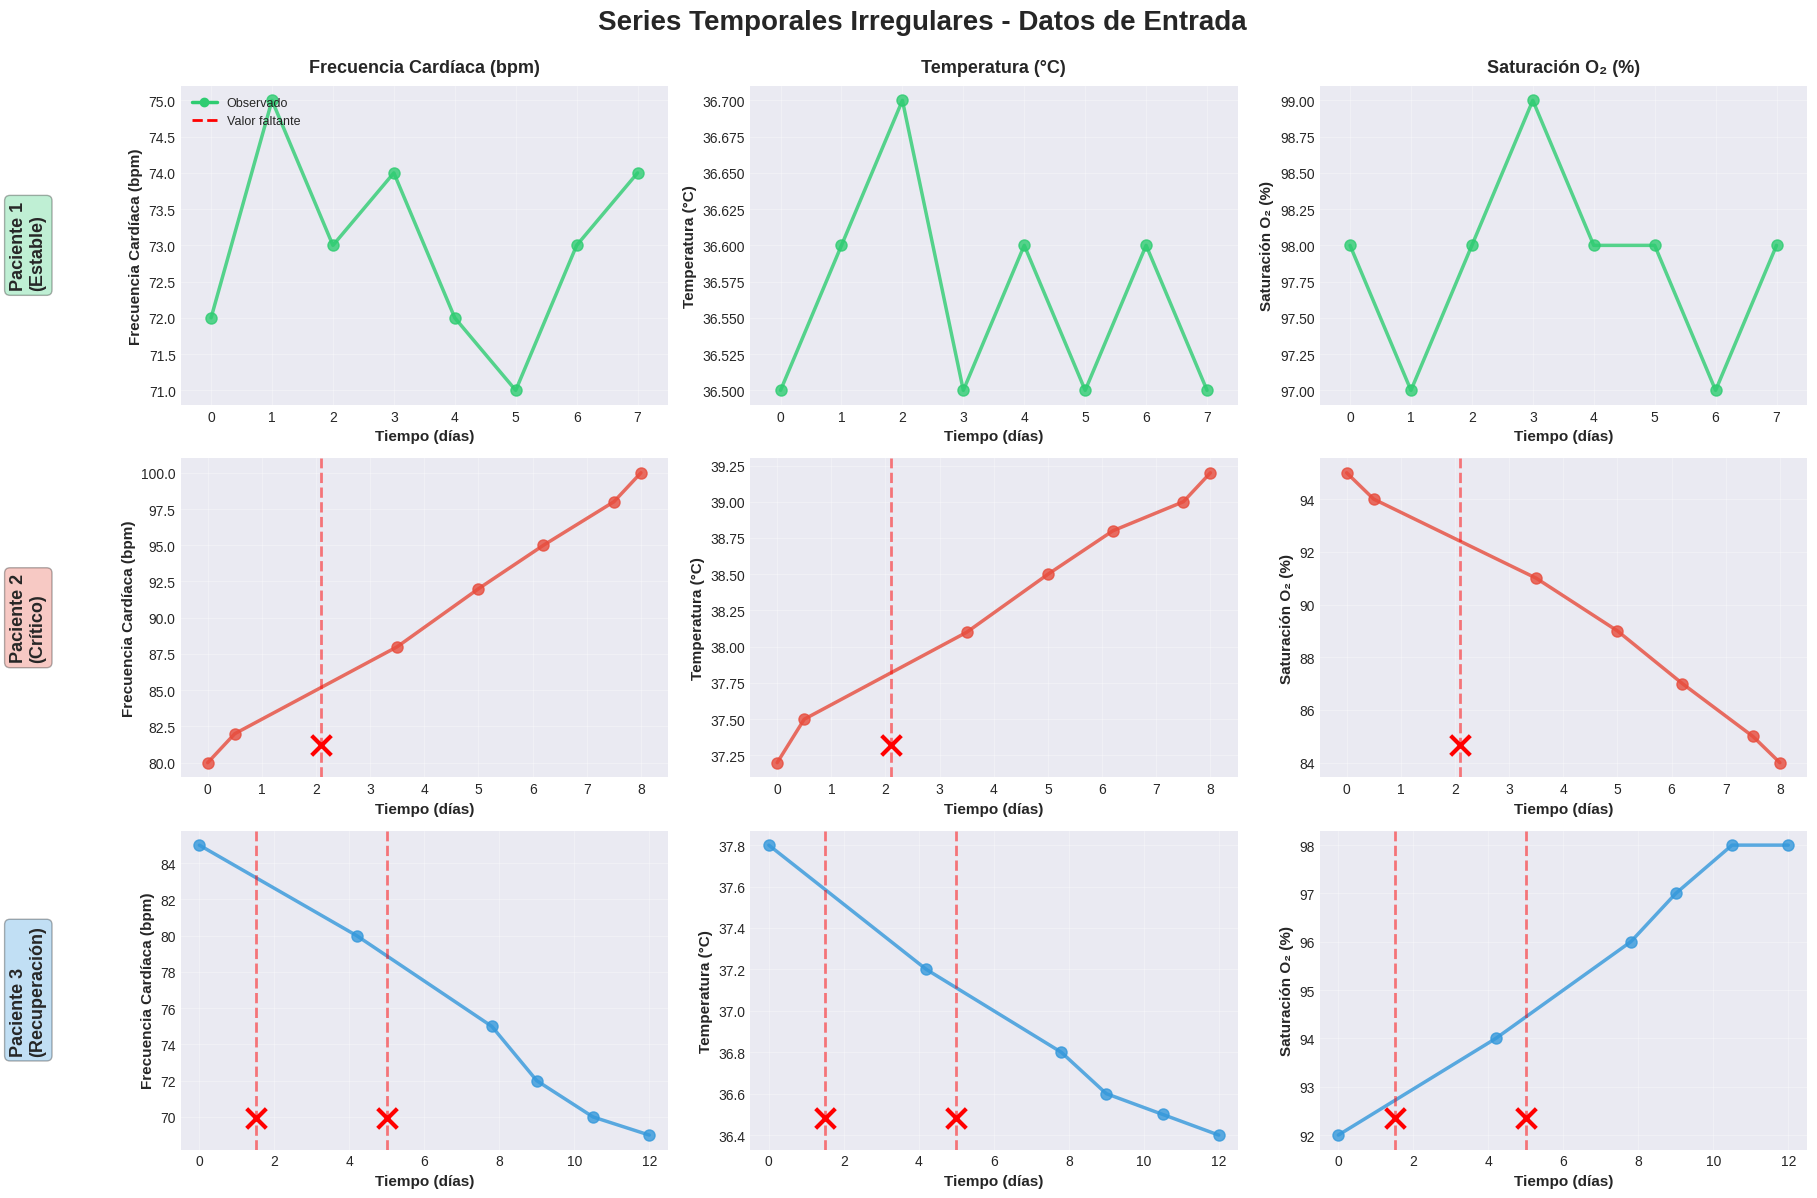

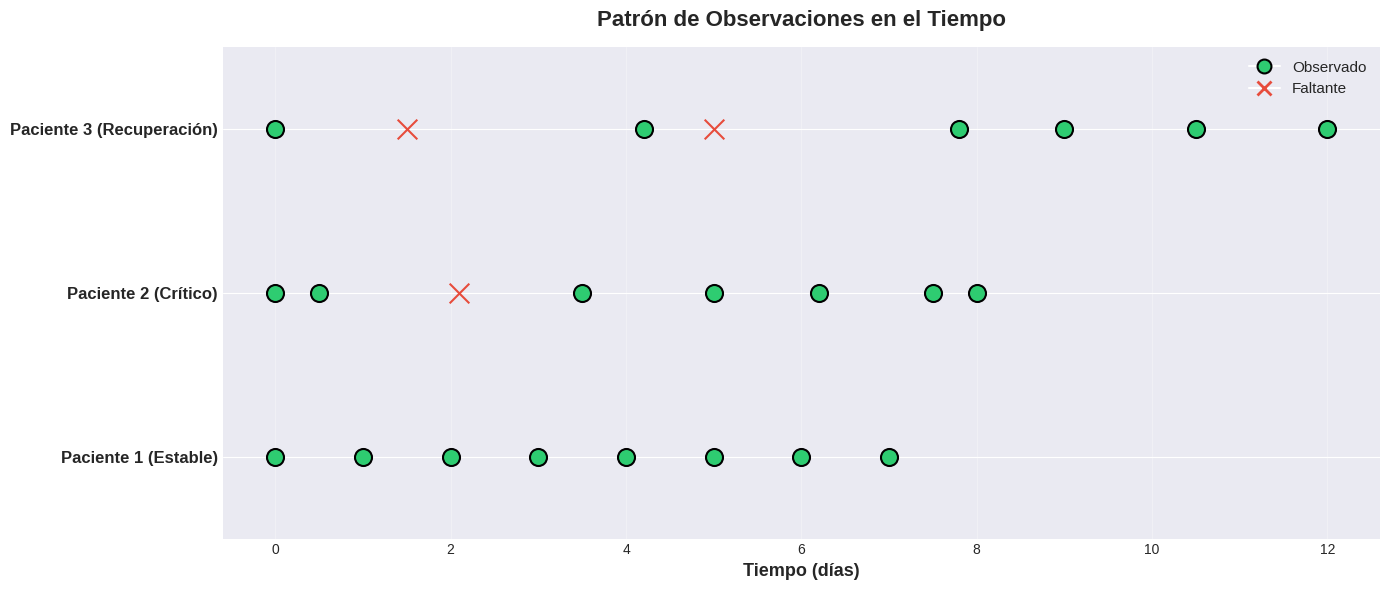

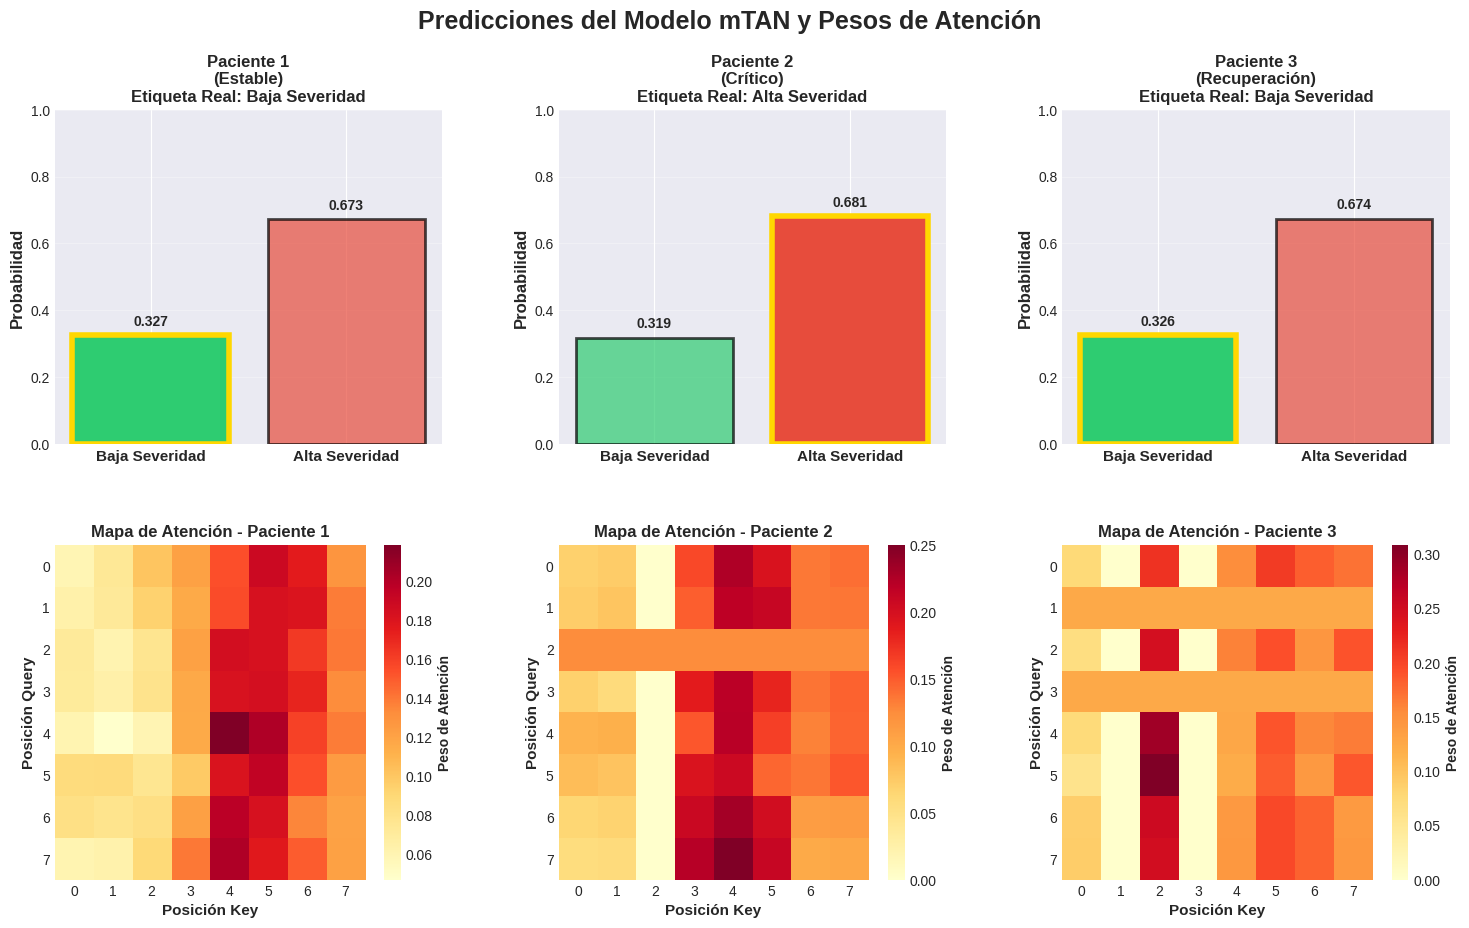

/home/gmartinez/Tesis/.venv/lib64/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/gmartinez/Tesis/.venv/lib64/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


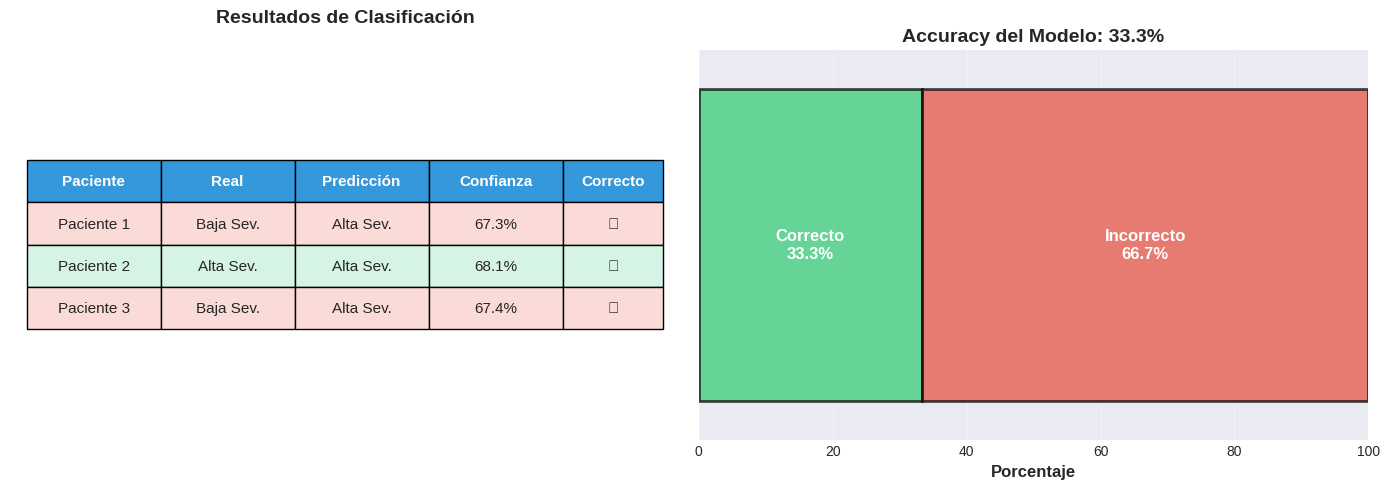

In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ===== PRIMERO: DEFINIR EL MODELO mTAN (versión simplificada) =====
# [Incluyo aquí las clases necesarias del código anterior]

class TimeAbsolutePositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.w = nn.Parameter(torch.randn(1, d_model))
        self.b = nn.Parameter(torch.randn(1, d_model))
        
    def forward(self, timestamps):
        timestamps = timestamps.unsqueeze(-1)
        time_encoding = timestamps * self.w + self.b
        time_encoding = torch.cos(time_encoding)
        return time_encoding


class MultiTimeAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.time_query = TimeAbsolutePositionalEncoding(d_model)
        self.time_key = TimeAbsolutePositionalEncoding(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, query_times, key_times, mask=None):
        batch_size = query.size(0)
        
        time_query_encoding = self.time_query(query_times)
        time_key_encoding = self.time_key(key_times)
        
        query_with_time = query + time_query_encoding
        key_with_time = key + time_key_encoding
        
        Q = self.W_q(query_with_time)
        K = self.W_k(key_with_time)
        V = self.W_v(value)
        
        Q = Q.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous()
        context = context.view(batch_size, -1, self.d_model)
        
        output = self.W_o(context)
        
        return output, attention_weights


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))


class mTANEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        
        self.multi_time_attention = MultiTimeAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, timestamps, mask=None):
        attn_output, attn_weights = self.multi_time_attention(
            query=x, key=x, value=x,
            query_times=timestamps,
            key_times=timestamps,
            mask=mask
        )
        x = self.norm1(x + self.dropout(attn_output))
        
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x, attn_weights


class mTANEncoder(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, n_layers, d_ff, dropout=0.1):
        super().__init__()
        
        self.input_projection = nn.Linear(input_dim, d_model)
        
        self.layers = nn.ModuleList([
            mTANEncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, timestamps, mask=None):
        x = self.input_projection(x)
        x = self.dropout(x)
        
        attention_weights = []
        for layer in self.layers:
            x, attn_w = layer(x, timestamps, mask)
            attention_weights.append(attn_w)
        
        return x, attention_weights


class mTAN(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, n_layers, d_ff, 
                 output_dim, task='classification', dropout=0.1):
        super().__init__()
        
        self.task = task
        
        self.encoder = mTANEncoder(
            input_dim=input_dim,
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            d_ff=d_ff,
            dropout=dropout
        )
        
        self.aggregation = 'mean'
        
        self.output_layer = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_dim)
        )
        
    def forward(self, x, timestamps, mask=None):
        batch_size, seq_len, _ = x.shape
        
        if mask is not None:
            attn_mask = mask.unsqueeze(1) * mask.unsqueeze(2)
        else:
            attn_mask = None
        
        encoded, attention_weights = self.encoder(x, timestamps, attn_mask)
        
        if self.aggregation == 'mean':
            if mask is not None:
                mask_expanded = mask.unsqueeze(-1)
                aggregated = (encoded * mask_expanded).sum(dim=1) / mask_expanded.sum(dim=1)
            else:
                aggregated = encoded.mean(dim=1)
        elif self.aggregation == 'max':
            aggregated = encoded.max(dim=1)[0]
        elif self.aggregation == 'last':
            aggregated = encoded[:, -1, :]
        
        output = self.output_layer(aggregated)
        
        if self.task == 'classification':
            output = torch.log_softmax(output, dim=-1)
        
        return output, attention_weights


# ===== CREAR DATOS DE EJEMPLO =====
def create_example_data():
    """Crear datos de ejemplo más realistas"""
    
    # PACIENTE 1: Estable (clase 0 - baja severidad)
    x_patient1 = torch.tensor([
        [72.0, 36.5, 98.0],  # FC, Temp, O2
        [75.0, 36.6, 97.0],
        [73.0, 36.7, 98.0],
        [74.0, 36.5, 99.0],
        [72.0, 36.6, 98.0],
        [71.0, 36.5, 98.0],
        [73.0, 36.6, 97.0],
        [74.0, 36.5, 98.0],
    ], dtype=torch.float32)
    timestamps_patient1 = torch.tensor([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])
    mask_patient1 = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1])
    label_patient1 = 0  # Baja severidad
    
    # PACIENTE 2: Deteriorándose (clase 1 - alta severidad)
    x_patient2 = torch.tensor([
        [80.0, 37.2, 95.0],
        [82.0, 37.5, 94.0],
        [0.0,  0.0,  0.0],   # FALTANTE
        [88.0, 38.1, 91.0],
        [92.0, 38.5, 89.0],
        [95.0, 38.8, 87.0],
        [98.0, 39.0, 85.0],
        [100.0, 39.2, 84.0],
    ], dtype=torch.float32)
    timestamps_patient2 = torch.tensor([0.0, 0.5, 2.1, 3.5, 5.0, 6.2, 7.5, 8.0])
    mask_patient2 = torch.tensor([1, 1, 0, 1, 1, 1, 1, 1])
    label_patient2 = 1  # Alta severidad
    
    # PACIENTE 3: Recuperándose (clase 0 - baja severidad)
    x_patient3 = torch.tensor([
        [85.0, 37.8, 92.0],
        [0.0,  0.0,  0.0],   # FALTANTE
        [80.0, 37.2, 94.0],
        [0.0,  0.0,  0.0],   # FALTANTE
        [75.0, 36.8, 96.0],
        [72.0, 36.6, 97.0],
        [70.0, 36.5, 98.0],
        [69.0, 36.4, 98.0],
    ], dtype=torch.float32)
    timestamps_patient3 = torch.tensor([0.0, 1.5, 4.2, 5.0, 7.8, 9.0, 10.5, 12.0])
    mask_patient3 = torch.tensor([1, 0, 1, 0, 1, 1, 1, 1])
    label_patient3 = 0  # Baja severidad
    
    # Combinar
    x = torch.stack([x_patient1, x_patient2, x_patient3])
    timestamps = torch.stack([timestamps_patient1, timestamps_patient2, timestamps_patient3])
    mask = torch.stack([mask_patient1, mask_patient2, mask_patient3])
    labels = torch.tensor([label_patient1, label_patient2, label_patient3])
    
    return x, timestamps, mask, labels


# ===== VISUALIZACIÓN 1: SERIES TEMPORALES =====
def plot_time_series(x, timestamps, mask, labels):
    """Visualizar las series temporales con valores faltantes"""
    
    variable_names = ['Frecuencia Cardíaca (bpm)', 'Temperatura (°C)', 'Saturación O₂ (%)']
    patient_names = ['Paciente 1\n(Estable)', 'Paciente 2\n(Crítico)', 'Paciente 3\n(Recuperación)']
    colors = ['#2ecc71', '#e74c3c', '#3498db']
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle('Series Temporales Irregulares - Datos de Entrada', 
                 fontsize=20, fontweight='bold', y=0.995)
    
    for patient_idx in range(3):
        for var_idx in range(3):
            ax = axes[patient_idx, var_idx]
            
            # Extraer datos
            times = timestamps[patient_idx].numpy()
            values = x[patient_idx, :, var_idx].numpy()
            mask_values = mask[patient_idx].numpy()
            
            # Separar valores observados y faltantes
            observed_times = times[mask_values == 1]
            observed_values = values[mask_values == 1]
            missing_times = times[mask_values == 0]
            
            # Plot valores observados
            ax.plot(observed_times, observed_values, 
                   marker='o', markersize=8, linewidth=2.5, 
                   color=colors[patient_idx], label='Observado',
                   alpha=0.8)
            
            # Marcar valores faltantes
            if len(missing_times) > 0:
                for mt in missing_times:
                    ax.axvline(x=mt, color='red', linestyle='--', 
                              alpha=0.5, linewidth=2)
                    ax.scatter([mt], [ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.1], 
                             marker='x', s=200, color='red', 
                             linewidths=3, zorder=5)
            
            # Configurar ejes
            ax.set_xlabel('Tiempo (días)', fontsize=11, fontweight='bold')
            ax.set_ylabel(variable_names[var_idx], fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlim(-0.5, max(times) + 0.5)
            
            # Título solo en la primera fila
            if patient_idx == 0:
                ax.set_title(variable_names[var_idx], fontsize=13, fontweight='bold', pad=10)
            
            # Etiqueta del paciente solo en la primera columna
            if var_idx == 0:
                ax.text(-0.35, 0.5, patient_names[patient_idx], 
                       transform=ax.transAxes,
                       fontsize=13, fontweight='bold',
                       verticalalignment='center',
                       rotation=90,
                       bbox=dict(boxstyle='round', facecolor=colors[patient_idx], alpha=0.3))
            
            # Leyenda solo en el primer subplot
            if patient_idx == 0 and var_idx == 0:
                missing_line = plt.Line2D([0], [0], color='red', linestyle='--', 
                                         linewidth=2, label='Valor faltante')
                ax.legend(handles=[plt.Line2D([0], [0], color=colors[patient_idx], 
                                             marker='o', linewidth=2.5, label='Observado'),
                                 missing_line], 
                         loc='upper left', fontsize=9)
    
    plt.tight_layout()
    return fig


# ===== VISUALIZACIÓN 2: MÁSCARA DE OBSERVACIONES =====
def plot_observation_mask(timestamps, mask):
    """Visualizar patrón de observaciones"""
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    patient_names = ['Paciente 1 (Estable)', 'Paciente 2 (Crítico)', 'Paciente 3 (Recuperación)']
    colors_obs = ['#2ecc71', '#e74c3c']
    
    for patient_idx in range(3):
        times = timestamps[patient_idx].numpy()
        mask_values = mask[patient_idx].numpy()
        
        for time_idx, (t, m) in enumerate(zip(times, mask_values)):
            color = colors_obs[0] if m == 1 else colors_obs[1]
            marker = 'o' if m == 1 else 'x'
            size = 150 if m == 1 else 200
            
            ax.scatter(t, patient_idx, c=color, marker=marker, s=size, 
                      edgecolors='black', linewidths=1.5, zorder=3)
    
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(patient_names, fontsize=12, fontweight='bold')
    ax.set_xlabel('Tiempo (días)', fontsize=13, fontweight='bold')
    ax.set_title('Patrón de Observaciones en el Tiempo', 
                fontsize=16, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, axis='x')
    ax.set_ylim(-0.5, 2.5)
    
    # Leyenda
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_obs[0], 
               markersize=10, label='Observado', markeredgecolor='black', markeredgewidth=1.5),
        Line2D([0], [0], marker='x', color='w', markerfacecolor=colors_obs[1], 
               markersize=10, label='Faltante', markeredgecolor=colors_obs[1], markeredgewidth=2)
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=11, framealpha=0.9)
    
    plt.tight_layout()
    return fig


# ===== VISUALIZACIÓN 3: PREDICCIONES DEL MODELO =====
def plot_predictions(output, labels, attention_weights):
    """Visualizar predicciones y pesos de atención"""
    
    # Convertir log-probabilidades a probabilidades
    probs = torch.exp(output).detach().numpy()
    labels_np = labels.numpy()
    
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Colores
    colors = ['#2ecc71', '#e74c3c', '#3498db']
    patient_names = ['Paciente 1\n(Estable)', 'Paciente 2\n(Crítico)', 'Paciente 3\n(Recuperación)']
    class_names = ['Baja Severidad', 'Alta Severidad']
    
    # FILA 1: Probabilidades de predicción
    for patient_idx in range(3):
        ax = fig.add_subplot(gs[0, patient_idx])
        
        prob_low = probs[patient_idx, 0]
        prob_high = probs[patient_idx, 1]
        true_label = labels_np[patient_idx]
        
        bars = ax.bar([0, 1], [prob_low, prob_high], 
                     color=[colors[0], colors[1]], alpha=0.7, edgecolor='black', linewidth=2)
        
        # Resaltar la clase verdadera
        bars[true_label].set_alpha(1.0)
        bars[true_label].set_edgecolor('gold')
        bars[true_label].set_linewidth(4)
        
        ax.set_xticks([0, 1])
        ax.set_xticklabels(class_names, fontsize=11, fontweight='bold')
        ax.set_ylabel('Probabilidad', fontsize=12, fontweight='bold')
        ax.set_ylim(0, 1)
        ax.set_title(f'{patient_names[patient_idx]}\nEtiqueta Real: {class_names[true_label]}', 
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Añadir valores en las barras
        for i, (bar, prob) in enumerate(zip(bars, [prob_low, prob_high])):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{prob:.3f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # FILA 2: Mapas de calor de atención (última capa, primera cabeza)
    for patient_idx in range(3):
        ax = fig.add_subplot(gs[1, patient_idx])
        
        # Obtener pesos de atención de la última capa, primera cabeza
        attn = attention_weights[-1][patient_idx, 0, :, :].detach().numpy()
        
        im = ax.imshow(attn, cmap='YlOrRd', aspect='auto', interpolation='nearest')
        ax.set_xlabel('Posición Key', fontsize=11, fontweight='bold')
        ax.set_ylabel('Posición Query', fontsize=11, fontweight='bold')
        ax.set_title(f'Mapa de Atención - {patient_names[patient_idx].split()[0]} {patient_names[patient_idx].split()[1]}', 
                    fontsize=12, fontweight='bold')
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Peso de Atención', fontsize=10, fontweight='bold')
        
        # Añadir grid
        ax.set_xticks(np.arange(attn.shape[1]))
        ax.set_yticks(np.arange(attn.shape[0]))
        ax.grid(False)
    
    fig.suptitle('Predicciones del Modelo mTAN y Pesos de Atención', 
                fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    return fig


# ===== VISUALIZACIÓN 4: RESUMEN DE MÉTRICAS =====
def plot_summary(output, labels):
    """Resumen de métricas del modelo"""
    
    probs = torch.exp(output).detach().numpy()
    labels_np = labels.numpy()
    predictions = np.argmax(probs, axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Subplot 1: Tabla de resultados
    ax1 = axes[0]
    ax1.axis('tight')
    ax1.axis('off')
    
    table_data = []
    patient_names = ['Paciente 1', 'Paciente 2', 'Paciente 3']
    class_names = ['Baja Sev.', 'Alta Sev.']
    
    for i in range(3):
        pred_class = class_names[predictions[i]]
        true_class = class_names[labels_np[i]]
        confidence = probs[i, predictions[i]] * 100
        correct = '✓' if predictions[i] == labels_np[i] else '✗'
        
        table_data.append([
            patient_names[i],
            true_class,
            pred_class,
            f'{confidence:.1f}%',
            correct
        ])
    
    table = ax1.table(cellText=table_data,
                     colLabels=['Paciente', 'Real', 'Predicción', 'Confianza', 'Correcto'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.2, 0.2, 0.2, 0.2, 0.15])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    # Estilizar encabezados
    for i in range(5):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Colorear filas según corrección
    for i in range(3):
        color = '#d5f4e6' if predictions[i] == labels_np[i] else '#fadbd8'
        for j in range(5):
            table[(i+1, j)].set_facecolor(color)
    
    ax1.set_title('Resultados de Clasificación', fontsize=14, fontweight='bold', pad=20)
    
    # Subplot 2: Accuracy
    ax2 = axes[1]
    accuracy = np.mean(predictions == labels_np) * 100
    
    ax2.barh([0], [accuracy], color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=2)
    ax2.barh([0], [100 - accuracy], left=[accuracy], color='#e74c3c', alpha=0.7, 
            edgecolor='black', linewidth=2)
    
    ax2.set_xlim(0, 100)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_xlabel('Porcentaje', fontsize=12, fontweight='bold')
    ax2.set_yticks([])
    ax2.set_title(f'Accuracy del Modelo: {accuracy:.1f}%', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Añadir texto
    ax2.text(accuracy/2, 0, f'Correcto\n{accuracy:.1f}%', 
            ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    if 100 - accuracy > 5:
        ax2.text(accuracy + (100-accuracy)/2, 0, f'Incorrecto\n{100-accuracy:.1f}%', 
                ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    plt.tight_layout()
    return fig


# ===== EJECUTAR TODO =====
def main():
    print("=" * 70)
    print("VISUALIZACIÓN DE mTAN - SERIES TEMPORALES IRREGULARES")
    print("=" * 70)
    
    # 1. Crear datos
    print("\n[1/5] Creando datos de ejemplo...")
    x, timestamps, mask, labels = create_example_data()
    print(f"   ✓ Datos creados: {x.shape[0]} pacientes, {x.shape[1]} observaciones, {x.shape[2]} variables")
    
    # 2. Crear modelo
    print("\n[2/5] Inicializando modelo mTAN...")
    model = mTAN(
        input_dim=3,
        d_model=32,
        n_heads=2,
        n_layers=2,
        d_ff=64,
        output_dim=2,
        task='classification',
        dropout=0.1
    )
    print(f"   ✓ Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")
    
    # 3. Hacer predicciones
    print("\n[3/5] Generando predicciones...")
    model.eval()
    with torch.no_grad():
        output, attention_weights = model(x, timestamps, mask)
    print(f"   ✓ Predicciones generadas: {output.shape}")
    
    # 4. Crear visualizaciones
    print("\n[4/5] Creando visualizaciones...")
    
    print("   → Gráfico 1: Series temporales...")
    fig1 = plot_time_series(x, timestamps, mask, labels)
    plt.savefig('mtan_time_series.png', dpi=300, bbox_inches='tight')
    print("   ✓ Guardado: mtan_time_series.png")
    
    print("   → Gráfico 2: Patrón de observaciones...")
    fig2 = plot_observation_mask(timestamps, mask)
    plt.savefig('mtan_observation_pattern.png', dpi=300, bbox_inches='tight')
    print("   ✓ Guardado: mtan_observation_pattern.png")
    
    print("   → Gráfico 3: Predicciones y atención...")
    fig3 = plot_predictions(output, labels, attention_weights)
    plt.savefig('mtan_predictions.png', dpi=300, bbox_inches='tight')
    print("   ✓ Guardado: mtan_predictions.png")
    
    print("   → Gráfico 4: Resumen de métricas...")
    fig4 = plot_summary(output, labels)
    plt.savefig('mtan_summary.png', dpi=300, bbox_inches='tight')
    print("   ✓ Guardado: mtan_summary.png")
    
    # 5. Mostrar resultados
    print("\n[5/5] Resultados:")
    probs = torch.exp(output).detach().numpy()
    predictions = np.argmax(probs, axis=1)
    
    patient_names = ['Paciente 1 (Estable)', 'Paciente 2 (Crítico)', 'Paciente 3 (Recuperación)']
    class_names = ['Baja Severidad', 'Alta Severidad']
    
    for i in range(3):
        print(f"\n   {patient_names[i]}:")
        print(f"      Etiqueta real: {class_names[labels[i]]}")
        print(f"      Predicción: {class_names[predictions[i]]}")
        print(f"      Probabilidades: Baja={probs[i,0]:.3f}, Alta={probs[i,1]:.3f}")
        print(f"      Estado: {'✓ CORRECTO' if predictions[i] == labels[i] else '✗ INCORRECTO'}")
    
    accuracy = np.mean(predictions == labels.numpy()) * 100
    print(f"\n   Accuracy total: {accuracy:.1f}%")
    
    print("\n" + "=" * 70)
    print("VISUALIZACIÓN COMPLETADA")
    print("=" * 70)
    print("\nArchivos generados:")
    print("   • mtan_time_series.png - Series temporales con valores faltantes")
    print("   • mtan_observation_pattern.png - Patrón de observaciones")
    print("   • mtan_predictions.png - Predicciones y mapas de atención")
    print("   • mtan_summary.png - Resumen de métricas")
    
    plt.show()


if __name__ == "__main__":
    main()
